In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pyreadr
import itertools
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import get_train_val_loader, get_test_loader

In [2]:
def bernstein_polynomial(h, i, d):
    res = sc.special.comb(d,i)*np.power(h,i)*np.power((1-h), (d-i))
    return res

In [3]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:, 0] = -(1/0.25)*np.log(params[:,0])
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [4]:
def get_bernstein_polynomials(h, degree, coeff = None):
    d = np.arange(0,(degree+1))
    res = np.array(list(map(lambda x: bernstein_polynomial(h, x, degree), d)))
    if coeff is None:
        return res
    else:
        return np.matmul(coeff, res)

In [5]:
def corr_func(h, method, r, s):
    if method=="brown":
        res = np.power((h/r),s)
    elif method=="powexp":
        res = np.exp(-np.power((h/r),s))        
    elif method == "whitmat":
        res = np.power(2, float(1-s))/sc.special.gamma(s)*\
              np.power((h/r),2)*sc.special.kv(s, (h/r))
    return res    

In [6]:
def extremal_coefficient(h, method, r, s):
    if method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(corr_func(h, method, r, s))/2,loc = 0, scale = 1)    
    else:
        res = 1+np.sqrt(1-corr_func(h, method, r, s)/2)        
    return res    

In [7]:
def error_function(h, model, method, true, est):
    r_true, s_true = true
    r_est, s_est = est
    if method == "corr":
        error = np.power(corr_func(h, model, r_true, s_true)- corr_func(h, model, r_est, s_est),2)
    elif method =="ext":
        error = np.power(extremal_coefficient(h, model, r_true, s_true)- extremal_coefficient(h, model, r_est, s_est),2)
    return error

In [8]:
def get_imse(data, model, method):
    pred = data[0:2]
    params = data[2:4]
    error, _ = quad(error_function, 0, 40, args = (model, method, pred, params))
    return error

# Analyze MSE-IMSE comparison

In [150]:
n = 1000
model = "brown"
r_1 = np.random.uniform(0.5, 3, 1000)
s_1 = np.random.uniform(0, 1.5, 1000)
r_2 = np.random.uniform(0, 5, 1000)
s_2 = np.random.uniform(0, 2, 1000)

params = np.transpose(np.concatenate([r_1,s_1,r_2,s_2], axis = 0).reshape(4,n))

In [151]:
imse = np.array([get_imse(x, model, "ext") for x in params])
mse = np.mean(np.power(params[:,0:2] - params[:,2:4],2), axis = 1)

In [152]:
data = pd.DataFrame(params).rename({0:"r_1", 1:"s_1", 2:"r_2", 3:"s_2"}, axis = 1)
data["mse"] = mse
data["imse"] = imse

Text(0, 0.5, 'IMSE')

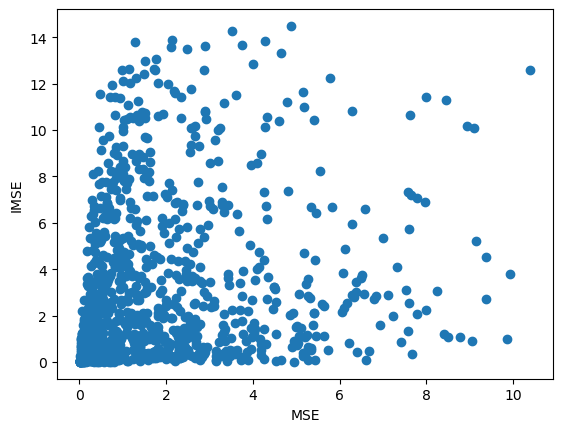

In [153]:
plt.scatter(data["mse"], data["imse"])
plt.xlabel("MSE")
plt.ylabel("IMSE")

# Small MSE, large IMSE

In [154]:
mse_q = data["mse"].quantile(0.2)
print(mse_q)
imse_q = data["imse"].quantile(0.90)
print(imse_q)

0.331792695941565
8.581486771053829


In [155]:
examples = data[data["mse"] < mse_q].sort_values(by = "imse", ascending = False).iloc[0:4,]

Text(0.5, 0.98, 'MSE 20%-Quantile: 0.33 - IMSE 90%-Quantile: 8.58')

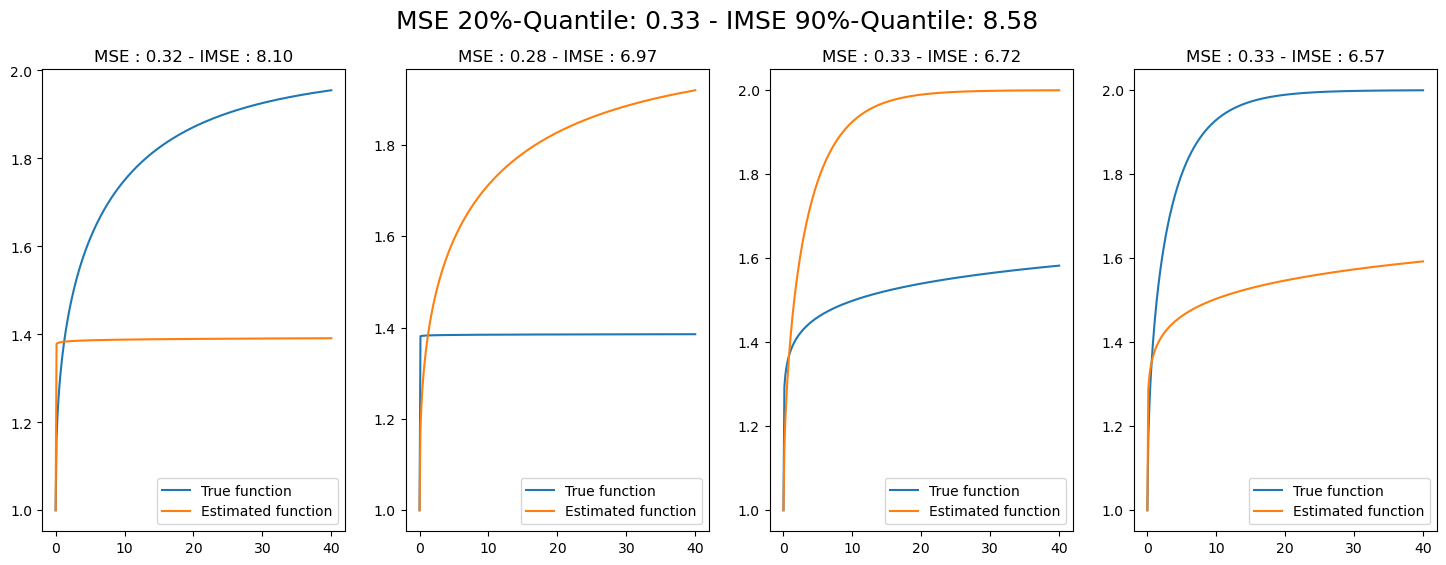

In [156]:
x = np.linspace(0,40,300)
fig, axs = plt.subplots(1,4, figsize = (18,6))
axs = axs.ravel()
for i in range(4):
    true = extremal_coefficient(x, model, examples.iloc[i,0], examples.iloc[i,1])
    pred = extremal_coefficient(x, model, examples.iloc[i,2], examples.iloc[i,3])
    

    axs[i].plot(x, true, label = "True function")
    axs[i].plot(x, pred, label = "Estimated function")
    axs[i].legend()
    axs[i].set_title(f"MSE : {examples.iloc[i,4]:.2f} - IMSE : {examples.iloc[i,5]:.2f}")
fig.suptitle(f"MSE 20%-Quantile: {mse_q:.2f} - IMSE 90%-Quantile: {imse_q:.2f}", fontsize = 18)

# Small IMSE, large MSE

In [157]:
mse_q = data["mse"].quantile(0.9)
print(mse_q)
imse_q = data["imse"].quantile(0.2)
print(imse_q)

4.784697209902423
0.3364887284999561


In [158]:
examples = data[data["imse"] < imse_q].sort_values(by = "mse", ascending = False).iloc[0:4,]

Text(0.5, 0.98, 'IMSE 20%-Quantile: 0.34 - MSE 90%-Quantile: 4.78')

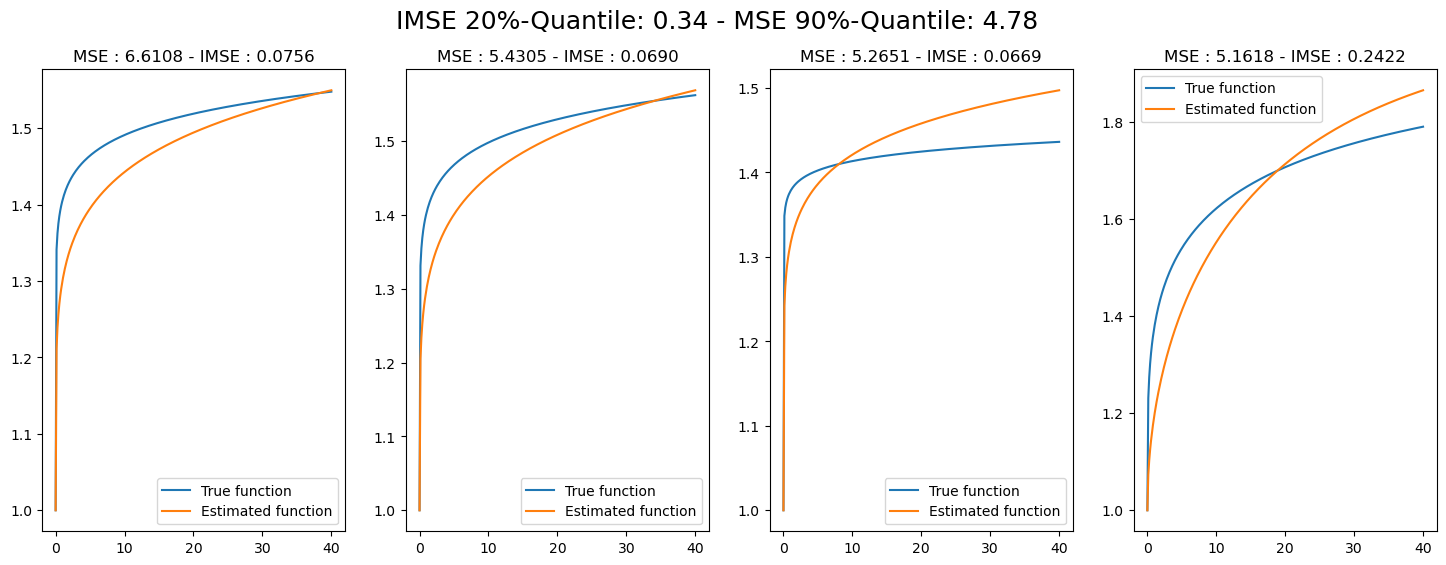

In [159]:
x = np.linspace(0,40,300)
fig, axs = plt.subplots(1,4, figsize = (18,6))
axs = axs.ravel()
for i in range(4):
    true = extremal_coefficient(x, model, examples.iloc[i,0], examples.iloc[i,1])
    pred = extremal_coefficient(x, model, examples.iloc[i,2], examples.iloc[i,3])    

    axs[i].plot(x, true, label = "True function")
    axs[i].plot(x, pred, label = "Estimated function")
    axs[i].legend()
    axs[i].set_title(f"MSE : {examples.iloc[i,4]:.4f} - IMSE : {examples.iloc[i,5]:.4f}")
fig.suptitle(f"IMSE 20%-Quantile: {imse_q:.2f} - MSE 90%-Quantile: {mse_q:.2f}", fontsize = 18)

# Analyze integrated correlation coefficient for examples

In [59]:
true = np.array([1.52550089, 1.984236  ])
pred = np.array([2.45755863, 1.14009845])

In [60]:
x = np.linspace(0,50,1000)
error = error_function(x, "brown", true, pred)
true =  corr_func(x, "brown", true[0], true[1])
est = corr_func(x, "brown", pred[0], pred[1])

TypeError: error_function() missing 1 required positional argument: 'est'

NameError: name 'error' is not defined

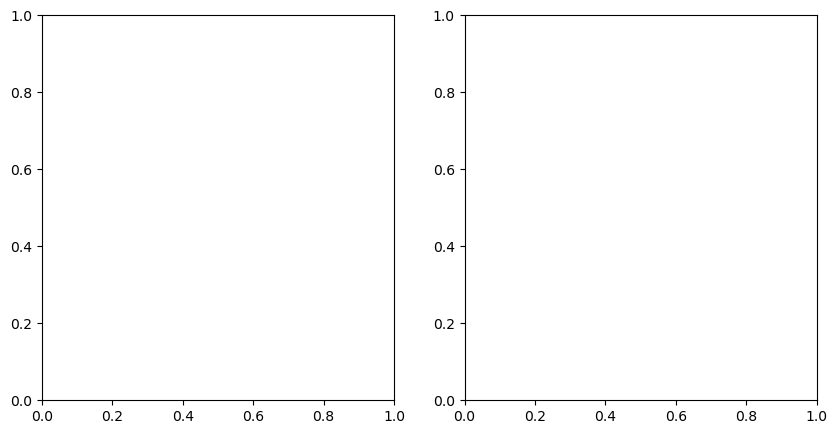

In [61]:
fig, axs = plt.subplots(1,2 ,figsize = (10,5))
axs[1].plot(x,error)
axs[0].plot(x,true)
axs[0].plot(x, est)
axs[0].legend(["True parameters", "PL Parameters"])
axs[1].legend(["Squared error"])
axs[1].set_title("Error function")
axs[0].set_title("Extremal coefficient")

# Plot extremal coefficient functions

In [16]:
x = np.linspace(0,15,500)
r = np.random.uniform(low = 0, high = 5, size = 10)
#r.sort()
s = np.random.uniform(low = 0, high = 2, size = 10)
#s.sort()
r_s = np.concatenate([np.expand_dims(r, axis = 1),np.expand_dims(s, axis = 1)], axis = 1)

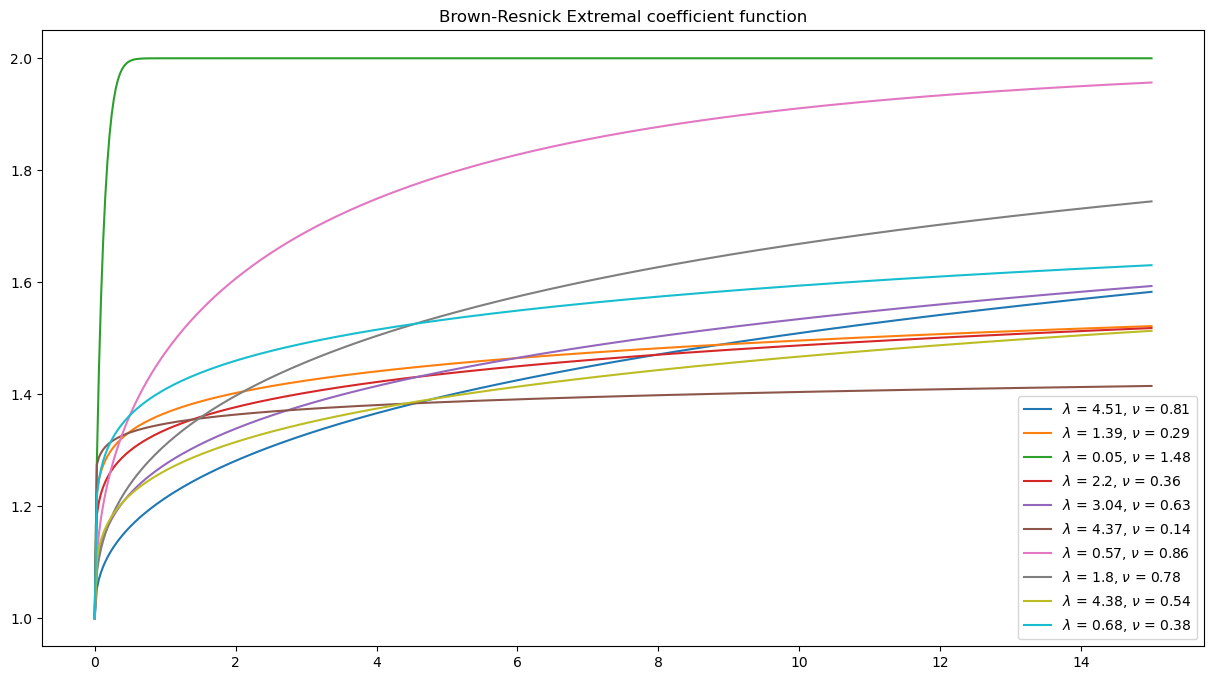

In [17]:
#Brown-Resnick
fig, axs = plt.subplots(figsize = (15,8))
for param in r_s:
    ext = extremal_coefficient(x, "brown", param[0], param[1])
    axs.plot(x,ext, label = fr'$\lambda$ = {np.round(param[0],2)}, $\nu$ = {np.round(param[1],2)}')
plt.title('Brown-Resnick Extremal coefficient function')
plt.legend()    

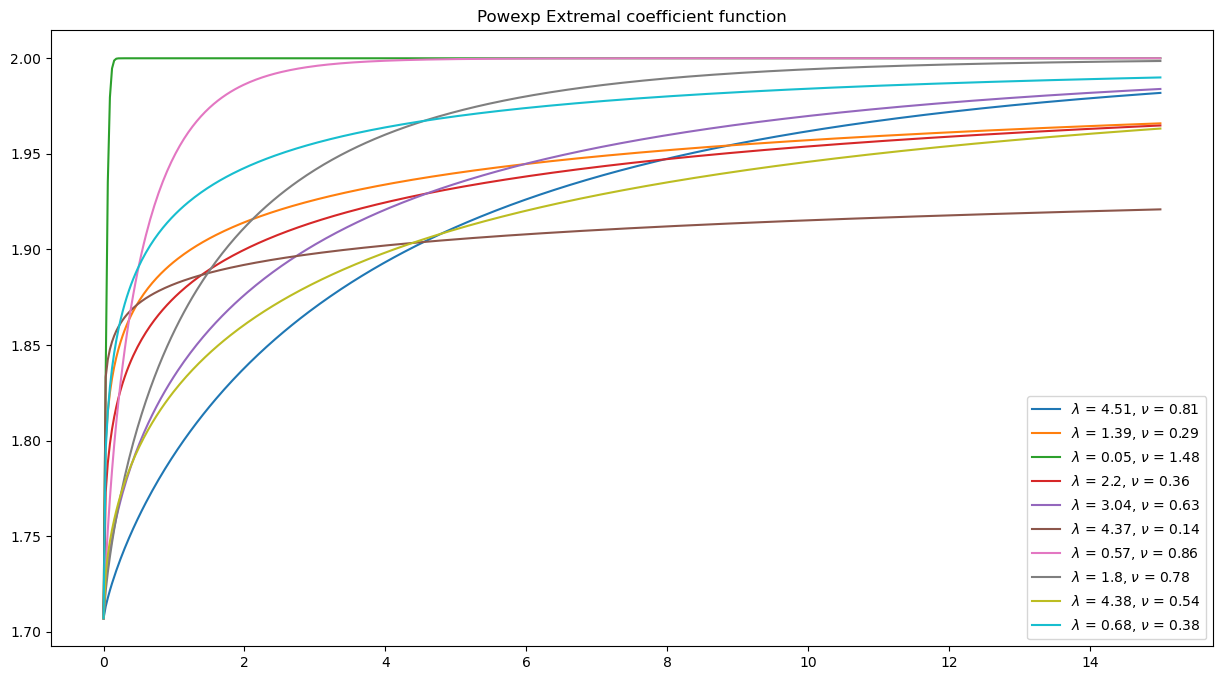

In [18]:
#Schlather
fig, axs = plt.subplots(figsize = (15,8))
for param in r_s:
    ext = extremal_coefficient(x, "powexp", param[0], param[1])
    axs.plot(x,ext, label = fr'$\lambda$ = {np.round(param[0],2)}, $\nu$ = {np.round(param[1],2)}')
plt.title('Powexp Extremal coefficient function')
plt.legend()   

# Compare crossings of extremal coefficient

In [9]:
sample_size = 50
x = np.linspace(0,15,500)
r = np.random.uniform(low = 0, high = 10, size = sample_size)
s = np.random.uniform(low = 0, high = 2, size = sample_size)
params_large = np.concatenate([np.expand_dims(r, axis = 1),np.expand_dims(s, axis = 1)], axis = 1)
r = np.random.uniform(low = 0, high = 3, size = sample_size)
s = np.random.uniform(low = 0, high = 2, size = sample_size)
params_small = np.concatenate([np.expand_dims(r, axis = 1),np.expand_dims(s, axis = 1)], axis = 1)

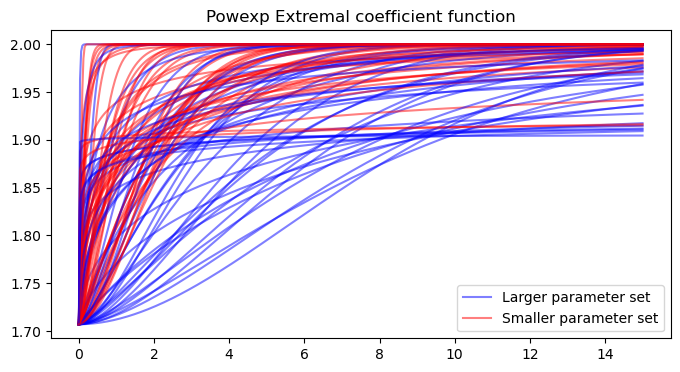

In [14]:
#Brown-Resnick
fig, axs = plt.subplots(figsize = (8,4))
for i in range(sample_size):
    ext_1 = extremal_coefficient(x, "powexp", params_large[i,0], params_large[i,1])
    ext_2 = extremal_coefficient(x, "powexp", params_small[i,0], params_small[i,1])
    axs.plot(x,ext_1, color = "blue", alpha = 0.5)
    axs.plot(x, ext_2, color = "red", alpha = 0.5)
plt.title('Powexp Extremal coefficient function')
plt.legend(["Larger parameter set", "Smaller parameter set"])   